In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.io import loadmat
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

## Define plotting functions

In [2]:
# Defining some generic useful stuff

major_ticks = np.arange(0.,1.1,0.2)
minor_ticks = np.arange(0.05,0.96,0.03)

sizeAndFonts = 'paper'

if sizeAndFonts == 'notebook':
    tksz = 15
    axfontsize=20
    lgfontsize=13
    figW = 5.5
    figH = 4.5
    figsize = (figW,figH)
    figsizeSubplots = (13.5,4.5)
    figsizeE = (8,4.5)
elif sizeAndFonts == 'paper':
    tksz = 40
    axfontsize=50
    lgfontsize=30
    figW = 11
    figH = 9
    figsize = (figW,figH)
    figsizeSubplots = (27,9)
    figsizeE = (16,9)


gridAlpha = 0.8

colors = cm.plasma_r(np.linspace(0.2,0.8,5))

Pr = 1.

def set_ax_params(ax,grid=False):
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticks(major_ticks)
    ax.set_xlabel(r'$\chi = r_i/r_o$',fontsize=axfontsize)
    
    if grid:
       ax.grid(True,which='minor', alpha=gridAlpha,axis='x',color='gray',ls='-')
       for x in [0.2,0.5,0.8]:
           ax.axvline(x=x,alpha=gridAlpha,color='gray',lw=0.5,zorder=-3)
    else:
        ax.grid(False)

    ax.tick_params(which='major',labelsize=tksz,length=10,direction='out')
    ax.tick_params(which='minor',length=5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')


def plot_crit(chi,ek,dat):
    fig, ax = plt.subplots(figsize=figsize)

    for k, ekk in enumerate(ek):
        expIdx = int(np.log10(ekk))
        label = r'$10^{%d}$' %expIdx
        ax.semilogy(chi, dat[k,:], '-o',color=colors[k],label=label)
    
    set_ax_params(ax)
    
    return ax

## Load datasets

In [3]:
dat = loadmat('dataset_Jun28_2022.mat')

locals().update(dat) #Populates all variables: ek, chi, rac, mc, omc

ek = ek.flatten()
chi = chi.flatten()

dat2 = loadmat('chi0.35_downto_E1e-9.mat') # Dataset for chi=0.35, computed till Ek=1e-9

Ek_chi35  = dat2['Ek'].flatten()
rac_chi35 = dat2['rac'].flatten()
mc_chi35  = dat2['mc'].flatten()
omc_chi35 = dat2['omc'].flatten()

ek2d, chi2d = np.meshgrid(ek,chi,indexing='ij') # 2d grid of ek and chi to make matrix multiplications easier

## Definitions

$$E = \dfrac{\nu}{\Omega L^2}$$

$$Ra = \dfrac{\alpha g_o \Delta T L^3}{\nu\kappa}$$

where, $L = r_o - r_i$

# Figures for $m_c$, $Ra_c$ and $\omega_c$ without and with compensated scalings

$m_c \sim E^{-1/3},\,    Ra_c \sim E^{-4/3}, \, \omega_c \sim E^{1/3}$

Let us see how well these work.

## $m_c$

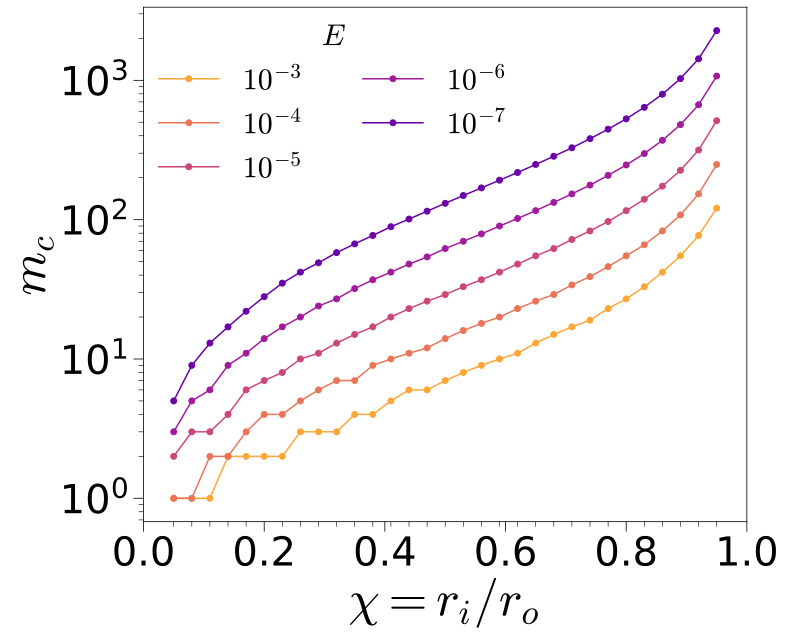

In [4]:
ax = plot_crit(chi,ek,mc)
ax.set_ylabel(r'${m}_c$',fontsize=axfontsize)
leg = ax.legend(shadow=False,fontsize=lgfontsize,framealpha=0,
                 frameon=True,edgecolor='none',
                 loc='upper left',
                 title=r'$E$',title_fontsize=lgfontsize,
                 ncol=2,
                 borderpad=0.01)
plt.tight_layout()

if sizeAndFonts == 'paper':
    plt.savefig('figures/mc_all_D.pdf')
else:
    plt.show()

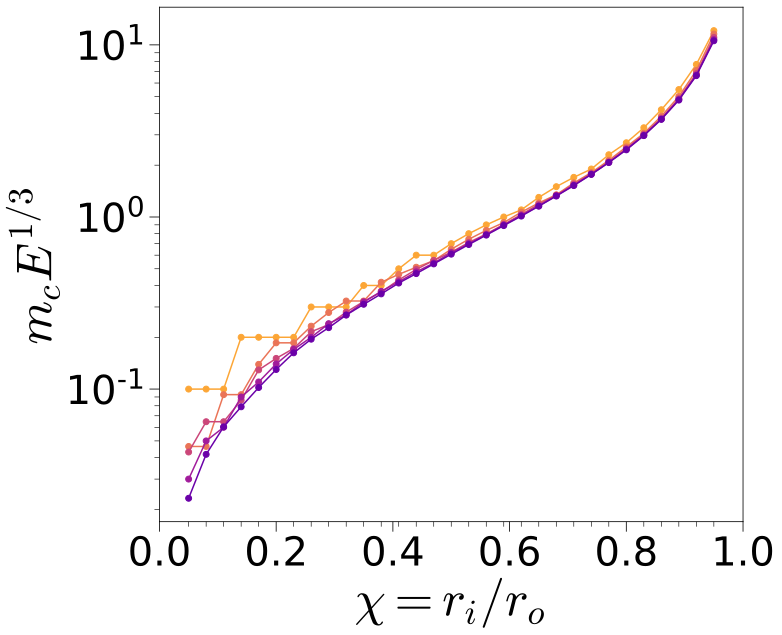

In [5]:
ax = plot_crit(chi,ek,mc * ek2d**(1./3.))
ax.set_ylabel(r'${m}_c E^{1/3}$',fontsize=axfontsize)
plt.tight_layout()
if sizeAndFonts == 'paper':
    plt.savefig('figures/mc_E13.pdf')
else:
    plt.show()

## $Ra_c$

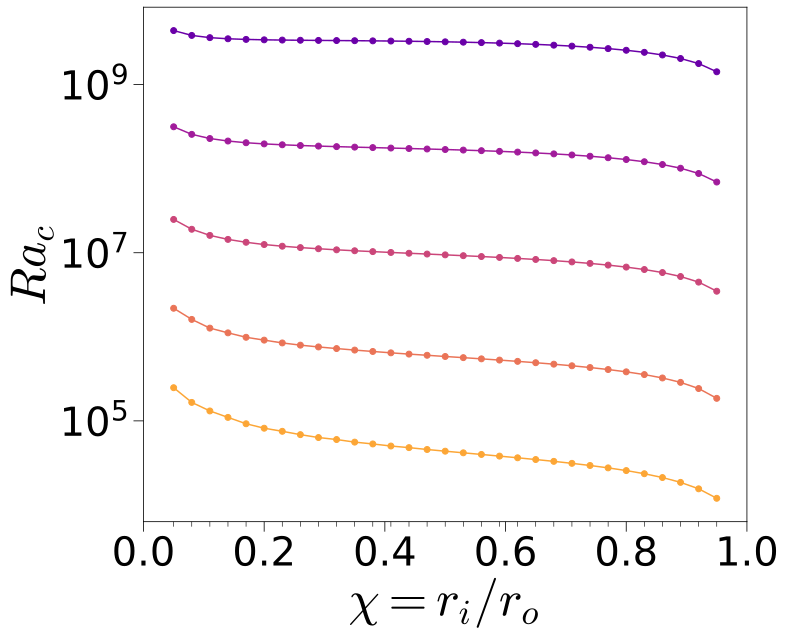

In [6]:
ax = plot_crit(chi,ek,rac)
ax.set_ylabel(r'${Ra}_c$',fontsize=axfontsize)
plt.tight_layout()
if sizeAndFonts == 'paper':
    plt.savefig('figures/rac_all_D.pdf')
else:
    plt.show()

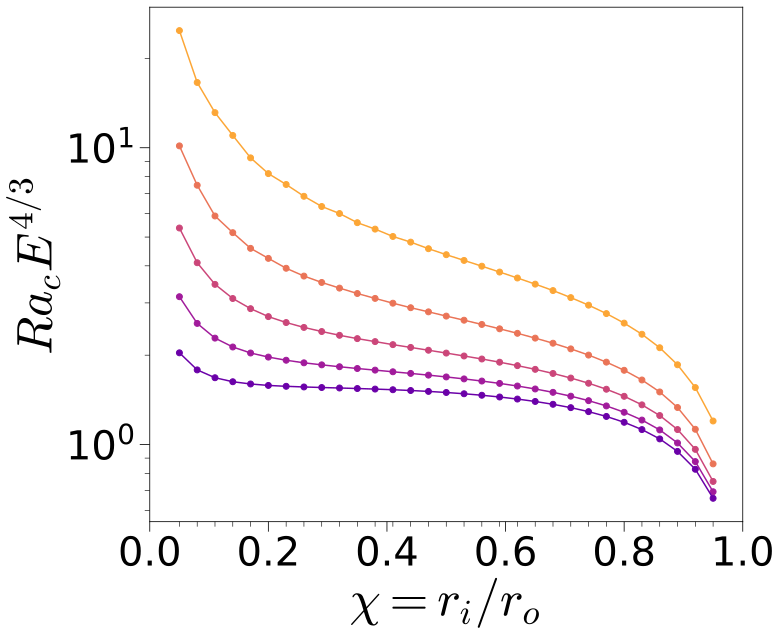

In [7]:
ax = plot_crit(chi,ek,rac * ek2d**(4./3.))
ax.set_ylabel(r'${Ra}_c E^{4/3}$',fontsize=axfontsize)
plt.tight_layout()
if sizeAndFonts == 'paper':
    plt.savefig('figures/rac_E43.pdf')
else:
    plt.show()

## $\omega_c$

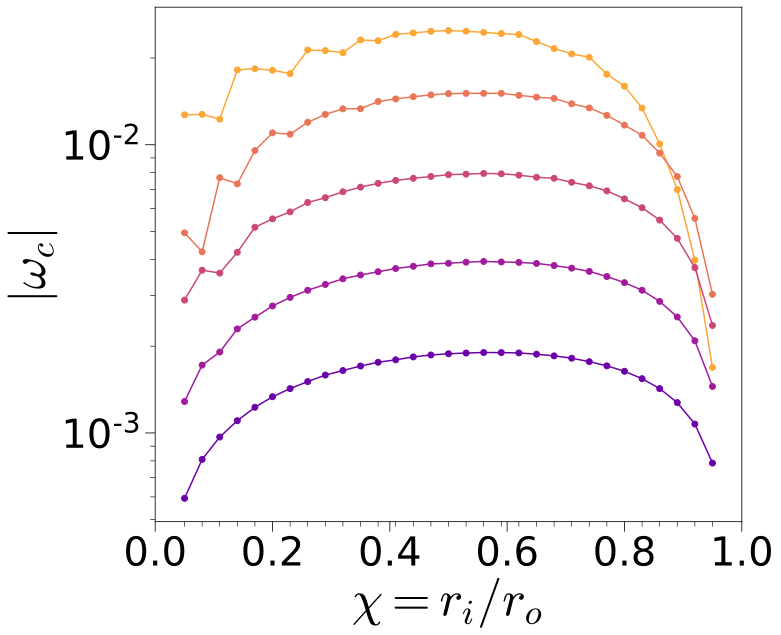

In [8]:
ax = plot_crit(chi,ek,np.abs(omc))
ax.set_ylabel(r'$|{\omega}_c|$',fontsize=axfontsize)
plt.tight_layout()
if sizeAndFonts == 'paper':
    plt.savefig('figures/omc_all_D.pdf')
else:
    plt.show()

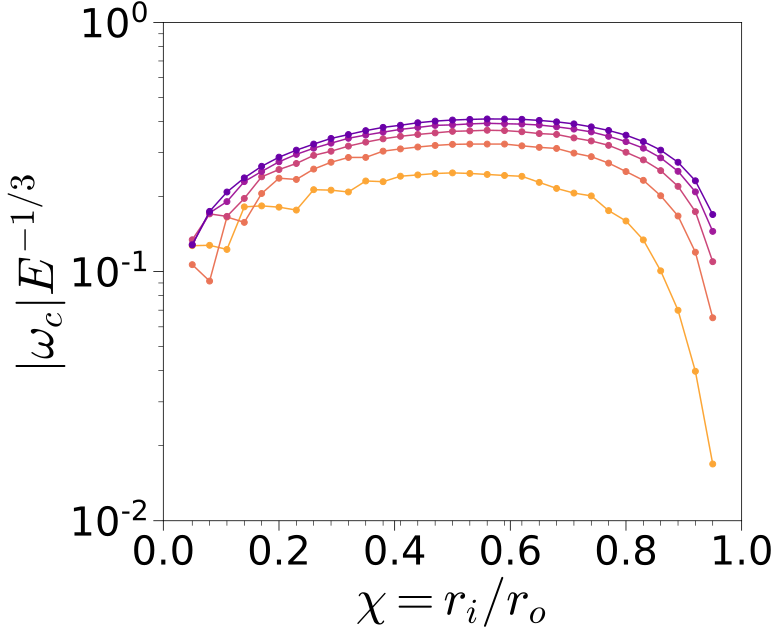

In [9]:
ax = plot_crit(chi,ek,np.abs(omc) * ek2d**(-1./3.))
ax.set_ylabel(r'$|{\omega}_c| E^{-1/3}$',fontsize=axfontsize)
ax.set_ylim(1e-2,1.)
plt.tight_layout()
if sizeAndFonts == 'paper':
    plt.savefig('figures/omc_E13.pdf')
else:
    plt.show()

# Variation in $m_c$

## Compensating with classic linear scaling: $m_c E^{1/3}$ and plotting variation with $\chi$

### Comparing fit errors

In the following, we perform a fit of $\hat{m_c} = m_c E^{1/3}$ to $f 2\pi/(\chi^{-1}-1)$ with $f$ being the fit parameter.
The first step is to compute the mean of $\hat{m_c}$ at one $\chi$.

The left plot shows the error if we perform the fit with only data smaller than a certain Ekman number (shown along the x-axis).
Three types of errors are computed:

$$\sqrt{(\frac{|m_c^{p} - m_c|}{m_c})^2}$$

 - Considering predicted and computed values for all $E$
 - Considering values for all $E \leq E_{fit}$ where fit is performed for all $E \leq E_{fit}$
 - Considering errors for $m_c$ for $E \leq 10^{-5} $
 
The analysis shows that performing the fit for $E \leq 10^{-5}$ is reasonable and would then yield a formula better applicable to low $E$.

The second (right) plot shows the value of $f$ when the fit is performed for Ekman number below the one on the x-axis.

a = 0.09169


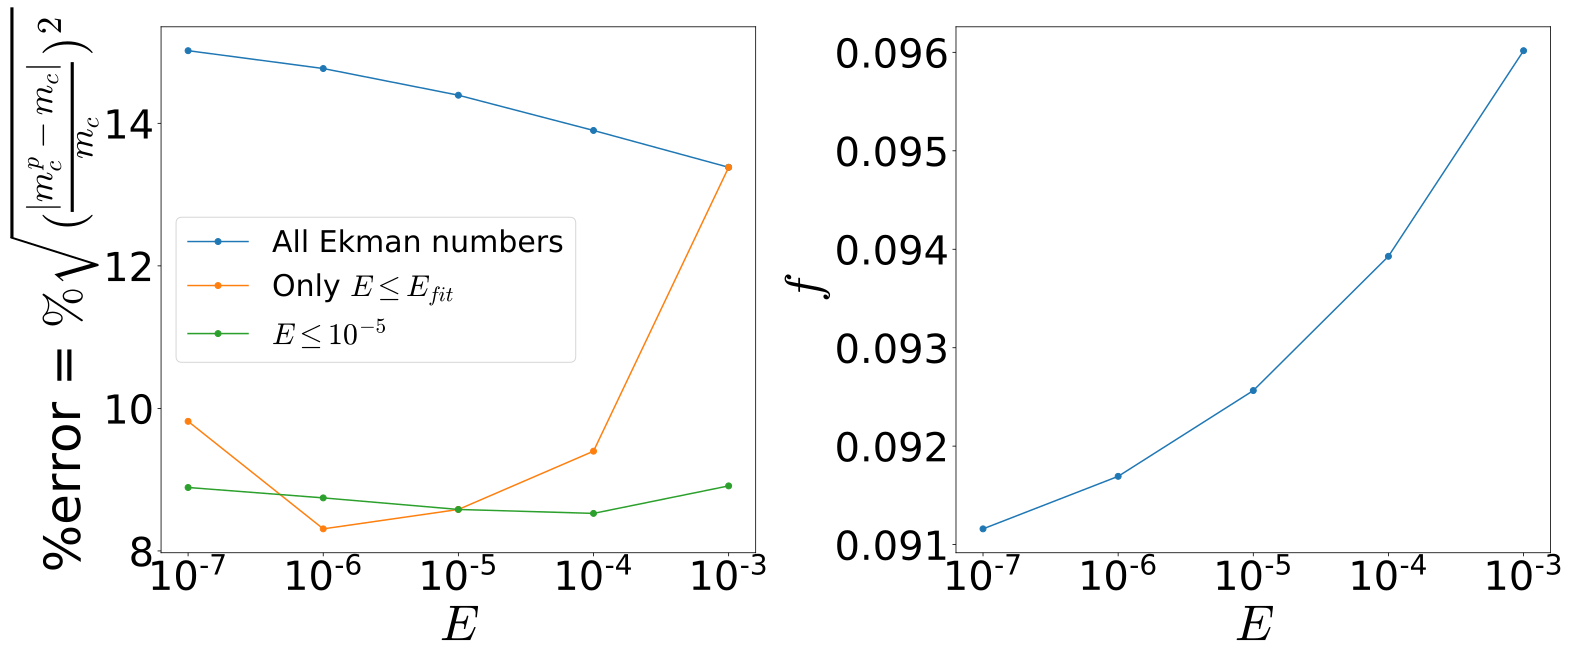

In [10]:
chi_sq = np.zeros_like(ek)
chi_sq_full = np.zeros_like(ek)
chi_sq_leq5 = np.zeros_like(ek)
fval = np.zeros_like(ek)
mchat = np.zeros_like(mc)

mchat = mc * ek2d**(1/3)

# Fitting function

def f(x,a):
    return 2*np.pi/(1./x - 1) * a  # a corresponds to f in the paper

for i in range(len(ek)):

    mcmean = mchat[i:,:].mean(axis=0)
    a, pcov = curve_fit(f,chi,mcmean)

    a = a[0]
    fval[i] = a

    ek2d,chi2d = np.meshgrid(ek,chi,indexing='ij')
    mc_pred = a * 2*np.pi/(1./chi2d - 1) * ek2d**(-1/3)
    chi_sq_tmp = (np.abs(mc - mc_pred)/mc)**2
    chi_sq_full[i] = np.sqrt(chi_sq_tmp.mean())
    
    ek2d,chi2d = np.meshgrid(ek[i:],chi,indexing='ij')
    mc_pred = a * 2*np.pi/(1./chi2d - 1) * ek2d**(-1/3)
    chi_sq_tmp = (np.abs(mc[i:,:] - mc_pred)/mc[i:,:])**2
    chi_sq[i] = np.sqrt(chi_sq_tmp.mean())
    
    ek2d,chi2d = np.meshgrid(ek[-3:],chi,indexing='ij')
    mc_pred = a * 2*np.pi/(1./chi2d - 1) * ek2d**(-1/3)
    chi_sq_tmp = (np.abs(mc[-3:,:] - mc_pred)/mc[-3:,:])**2
    chi_sq_leq5[i] = np.sqrt(chi_sq_tmp.mean())

a = fval[-2]
print("a = %.5f" %a)
    
plt.figure(figsize=(2*figW,figH))

plt.subplot(1,2,1)
plt.semilogx(ek,chi_sq_full*100,'-o',label='All Ekman numbers')
plt.semilogx(ek,chi_sq*100,'-o',label='Only $E \leq E_{fit}$')
plt.semilogx(ek,chi_sq_leq5*100,'-o',label='$E \leq 10^{-5}$')
plt.xticks([1e-3,1e-4,1e-5,1e-6,1e-7])
plt.xlabel(r'$E$',fontsize=axfontsize)
plt.ylabel(r'%error = $\% \sqrt{(\frac{|m_c^{p} - m_c|}{m_c})^2}$',fontsize=axfontsize)
plt.tick_params(labelsize=tksz)
plt.legend(fontsize=lgfontsize)

plt.subplot(1,2,2)
plt.semilogx(ek,fval,'-o')
plt.xticks([1e-3,1e-4,1e-5,1e-6,1e-7])
plt.xlabel(r'$E$',fontsize=axfontsize)
plt.ylabel(r'$f$',fontsize=axfontsize)
plt.tick_params(labelsize=tksz)


plt.tight_layout()
plt.show()

# Reset 2d grid

ek2d,chi2d = np.meshgrid(ek,chi,indexing='ij')

### Variation with $\chi$

#### Plotting the fit

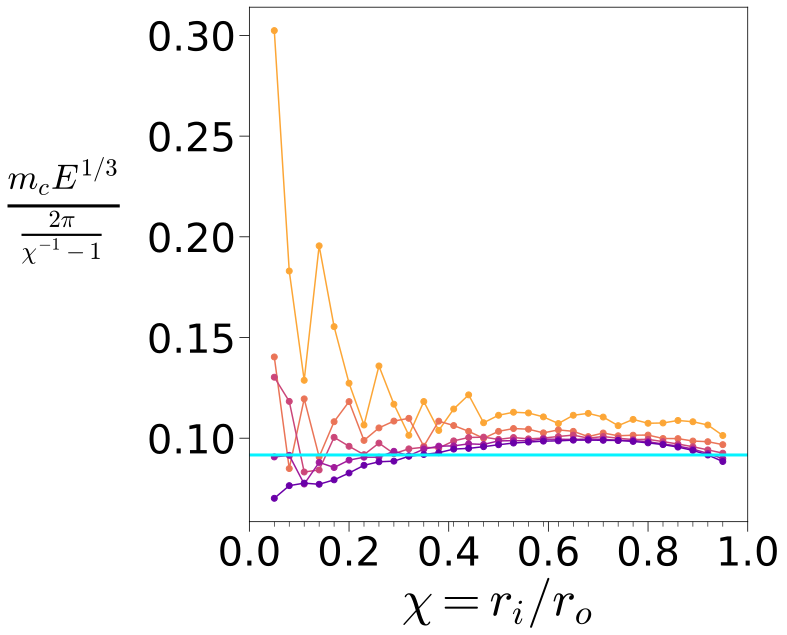

In [11]:
ax2 = plot_crit(chi,ek,mchat/(2*np.pi/(1/chi - 1)))
ax2.set_ylabel(r'$\frac{{m}_c E^{1/3}}{\frac{2\pi}{\chi^{-1} - 1}}$',
               fontsize=axfontsize,rotation=0,labelpad=80)

ax2.axhline(y=a,color='#05f3ff',lw=3,ls='-')
ax2.set_yscale('linear')
plt.tight_layout()
if sizeAndFonts == 'paper':
    plt.savefig('figures/mc_E13_chiComp.pdf',bbox_inches='tight')
else:
    plt.show()

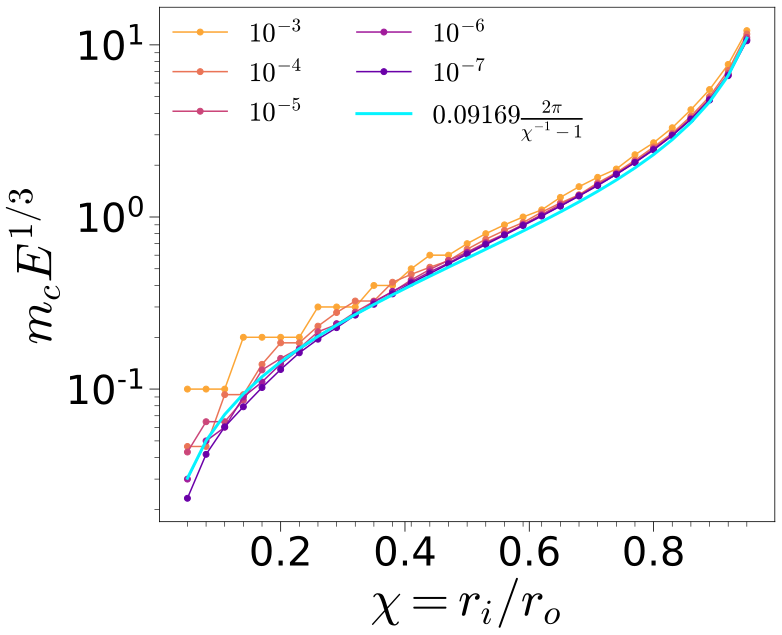

In [12]:
ax1 = plot_crit(chi,ek,mchat)
ax1.set_ylabel(r'${m}_c E^{1/3}$',fontsize=axfontsize)
ax1.plot(chi, 2*np.pi/(1/chi - 1) * a,lw=3,
         label=r'$%.5f\frac{2\pi}{\chi^{-1} - 1}$' %a,
         color='#05f3ff')

leg = ax1.legend(shadow=False,fontsize=0.9*lgfontsize,framealpha=1,
                 frameon=True,edgecolor='none',
                 loc='best',
                 ncol=2,
                 borderpad=0.01)
plt.tight_layout()

if sizeAndFonts == 'paper':
    plt.savefig('figures/mc_E13_chiFit.pdf',bbox_inches='tight')
else:
    plt.show()

### Prediction vs reality

In [13]:
'''
This produces a LaTeX table of Ekman number, radius ratio, computed m, predicted m, % error
'''

ekTest  = [1e-3,1e-4,1e-5,1e-6,1e-7]
chiTest = [0.11, 0.35, 0.71, 0.92,0.95]
#chiTest = [0.95]

a = np.round(a,decimals=5)

for ekIter in range(len(ek)):
    for i in range(len(ekTest)):
        if ek[ekIter] == ekTest[i]:
            for j in range(len(chi)):
                for k in range(len(chiTest)):
                    if chi[j] == chiTest[k]:
                        actual_m = int(mc[ekIter,j])
                        pred_m = int(np.round(a * ek[ekIter]**(-1/3.) * 2*np.pi/((1./chi[j]) - 1)))
                        exponent = int(np.log10(ek[ekIter]))
                        error = np.abs(actual_m - pred_m)/pred_m * 100
                        print("$10^{%d}$ & %.2f & %d & %d & %.1f\\\\" %(exponent,chi[j],actual_m,pred_m,error))

ekTest = 1e-9
chiTest = 0.35

pred_m = a * ekTest**(-1/3.) * 2*np.pi/((1./chiTest) - 1) 
error = np.abs(mc_chi35[-1] - pred_m)/pred_m * 100

print("$10^{-9}$ & %.2f & %d & %d & %.1f  \\\\" %(chiTest,mc_chi35[-1],pred_m,error))

$10^{-3}$ & 0.11 & 1 & 1 & 0.0\\
$10^{-3}$ & 0.35 & 4 & 3 & 33.3\\
$10^{-3}$ & 0.71 & 17 & 14 & 21.4\\
$10^{-3}$ & 0.92 & 77 & 66 & 16.7\\
$10^{-3}$ & 0.95 & 121 & 109 & 11.0\\
$10^{-4}$ & 0.11 & 2 & 2 & 0.0\\
$10^{-4}$ & 0.35 & 7 & 7 & 0.0\\
$10^{-4}$ & 0.71 & 34 & 30 & 13.3\\
$10^{-4}$ & 0.92 & 153 & 143 & 7.0\\
$10^{-4}$ & 0.95 & 249 & 236 & 5.5\\
$10^{-5}$ & 0.11 & 3 & 3 & 0.0\\
$10^{-5}$ & 0.35 & 15 & 14 & 7.1\\
$10^{-5}$ & 0.71 & 72 & 65 & 10.8\\
$10^{-5}$ & 0.92 & 316 & 308 & 2.6\\
$10^{-5}$ & 0.95 & 513 & 508 & 1.0\\
$10^{-6}$ & 0.11 & 6 & 7 & 14.3\\
$10^{-6}$ & 0.35 & 32 & 31 & 3.2\\
$10^{-6}$ & 0.71 & 153 & 141 & 8.5\\
$10^{-6}$ & 0.92 & 668 & 663 & 0.8\\
$10^{-6}$ & 0.95 & 1073 & 1095 & 2.0\\
$10^{-7}$ & 0.11 & 13 & 15 & 13.3\\
$10^{-7}$ & 0.35 & 67 & 67 & 0.0\\
$10^{-7}$ & 0.71 & 328 & 304 & 7.9\\
$10^{-7}$ & 0.92 & 1427 & 1427 & 0.0\\
$10^{-7}$ & 0.95 & 2275 & 2358 & 3.5\\
$10^{-9}$ & 0.35 & 305 & 310 & 1.7  \\


### Width of columns inside Earth

In [14]:
ekTest = 1e-15
chiTest = 0.35

mEarth = np.round(a * ekTest**(-1/3.) * 2*np.pi/((1./chiTest) - 1) )

width_column = 2*np.pi * 1220e3/mEarth

print("%d metres" %width_column)

247 metres


# Figures with respect to Ekman number, $E$ on the $x$-axis

In [15]:
#####################################
# Fake scalar mappable for colorbar #
#####################################

cmap_E = cm.rainbow
colors_E = cmap_E(np.linspace(0.05,0.95,len(chi)))

def fakeScalarMappable(chi):

    chi2D = np.meshgrid(chi,chi)

    sm = plt.cm.ScalarMappable(cmap=cmap_E, norm=plt.Normalize(vmin=0.05, vmax=0.95))
    sm._A = chi2D
    cbar = plt.colorbar(sm,aspect=50,ticks=np.arange(0.05,0.96,0.1))

    cbar.ax.set_ylabel(r'$\chi = r_i/r_o$',fontsize=axfontsize)
    cbar.ax.tick_params(labelsize=0.8*axfontsize)

def plotChiEarth(ax,critVar,Ekfac,facChi):
    
    ax.plot(Ek_chi35,critVar * Ek_chi35**Ekfac/facChi,'-o',
                color='k',label=r'$\chi = 0.35$',lw=3)
    ax.legend(fontsize=lgfontsize,framealpha=1)
    ax.set_xticks(Ek_chi35)
    ax.invert_xaxis()

def plot_crit_E(chi,ek,dat):
    fig, ax = plt.subplots(figsize=figsizeE)
    
    for k, kchi in enumerate(chi):
        ax.loglog(ek,dat[:,k],'-o',color=colors_E[k])
        
    ax.set_xlabel(r'$E$',fontsize=axfontsize)
    
    ax.grid(True,which='both', alpha=0.3,axis='both',color='gray',ls='-')
    ax.xaxis.grid(True, which='minor')

    ax.tick_params(which='major',axis='both',labelsize=tksz,direction='out',length=10)
    ax.tick_params(which='minor',axis='both',direction='out',length=5)
    
    return ax

## $m_c$

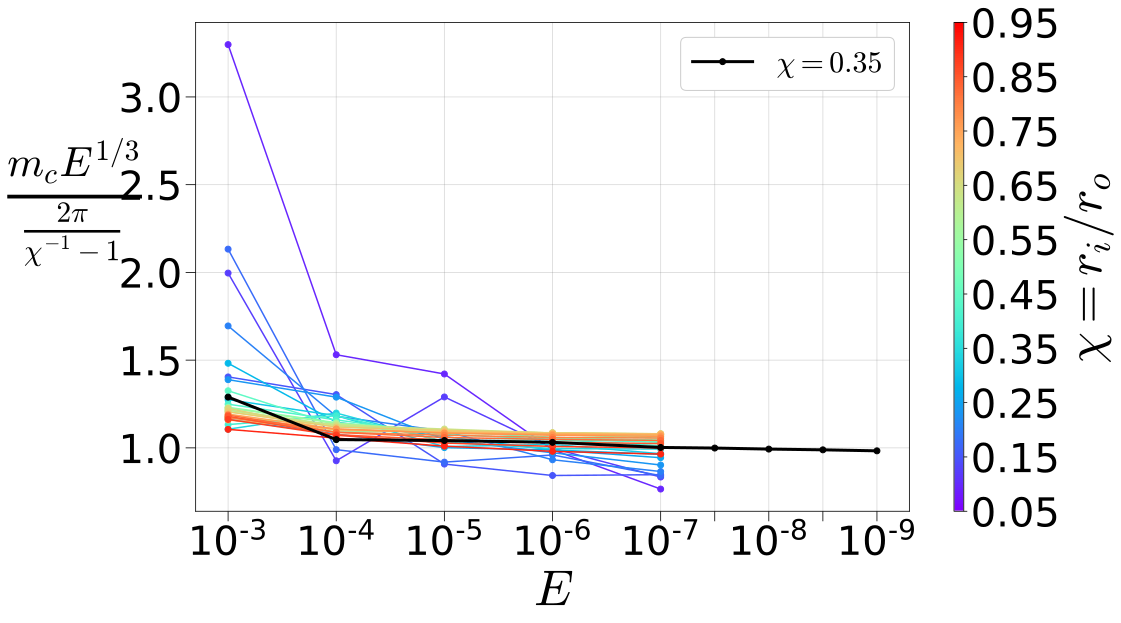

In [16]:
facChi = 2*np.pi*a/(1./chi2d - 1)
facChi_35 = 2*np.pi*a/(1./0.35 - 1)

dat = mc*ek2d**(1./3.)/facChi

ax = plot_crit_E(chi,ek,dat)

ax.set_ylabel(r'$\frac{{m}_c E^{1/3}}{\frac{2\pi}{\chi^{-1} - 1}}$',
              fontsize=1.2*axfontsize,rotation=0,labelpad=40)
ax.set_yscale('linear')

plotChiEarth(ax,mc_chi35,1./3.,facChi_35)
fakeScalarMappable(chi)

if sizeAndFonts == 'paper':
    plt.savefig('figures/mc_E.pdf',bbox_inches='tight')
else:
    plt.show()

## $Ra_c$

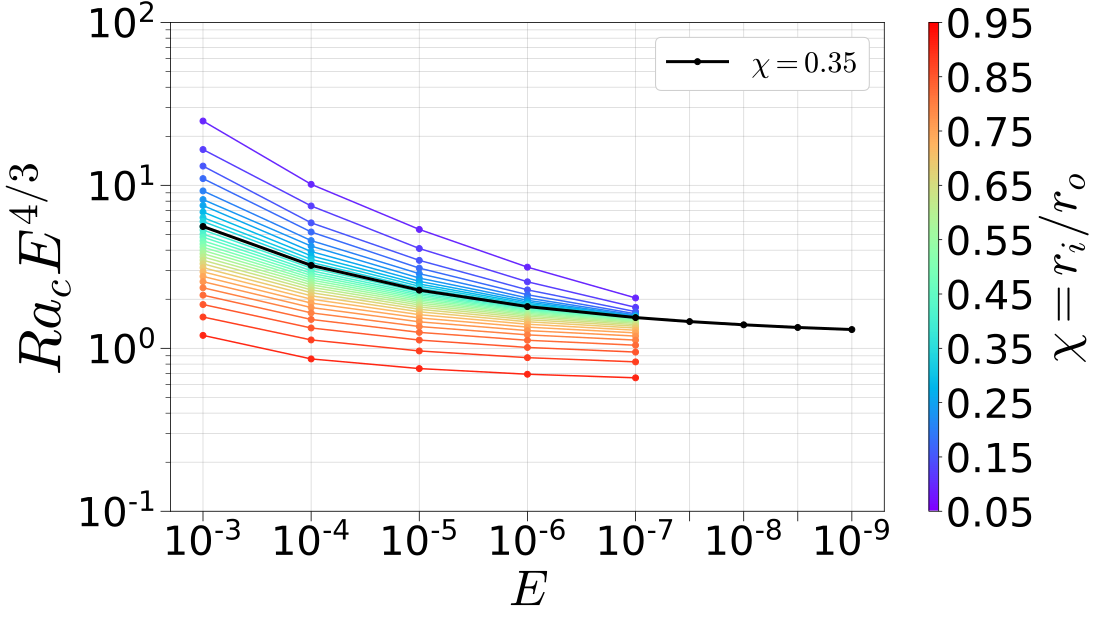

In [17]:
dat = rac*ek2d**(4./3.)

ax = plot_crit_E(chi,ek,dat)

ax.set_ylim(0.1,100)

ax.set_ylabel(r'${Ra}_c E^{4/3}$',
              fontsize=1.2*axfontsize)
ax.set_xlabel(r'$E$',fontsize=axfontsize)

plotChiEarth(ax,rac_chi35,4./3.,1.)
fakeScalarMappable(chi)

if sizeAndFonts == 'paper':
    plt.savefig('figures/EvRacE43.pdf',bbox_inches='tight')
else:
    plt.show()

## $\omega_c$

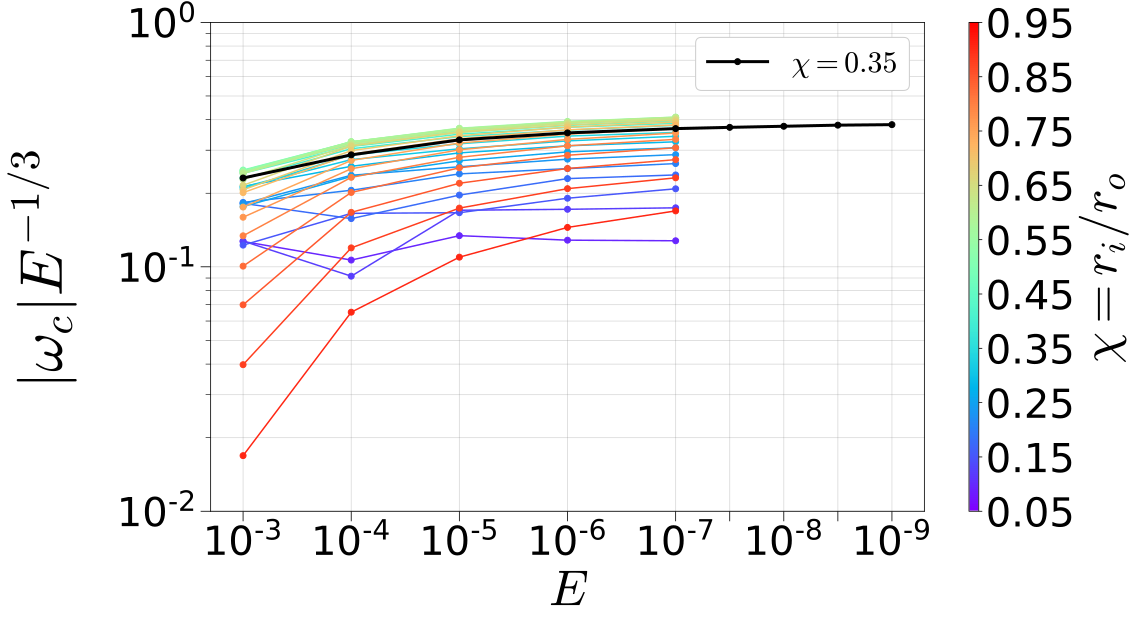

In [18]:
dat = np.abs(omc)*ek2d**(-1./3.)

ax = plot_crit_E(chi,ek,dat)

ax.set_ylim(1e-2,1)

ax.set_ylabel(r'$|{\omega}_c| E^{-1/3}$',
              fontsize=1.2*axfontsize,rotation=90,labelpad=40)
ax.set_xlabel(r'$E$',fontsize=axfontsize)
plotChiEarth(ax,np.abs(omc_chi35),-1./3.,1.)
fakeScalarMappable(chi)
if sizeAndFonts == 'paper':
    plt.savefig('figures/EvOmcE13.pdf',bbox_inches='tight')
else:
    plt.show()

# Interpolation

In [19]:
def interp_data(ekInterp,chiInterp, iplot=False):
    
    '''
    This function uses the dataset and interpolates to obtain a reasonable estimate of
    Rac and mc . The nearest chi value is chosen first and then a linear interpolation is
    performed in Ekman.
    
    ekInterp  : Ekman number to interpolate to
    chiInterp : Radius ratio to interpolate to
    iplot     : Bool for plotting a graphic illustration
    
    returns
    
    mcInterp : Interpolated mc
    racInterp: Interpolated rac
    
    '''
    
    fitIdx = np.argmin(np.abs(chi - chiInterp))
    # print("chi used : %.2f" %chi[fitIdx])

    p1 = np.polyfit(np.log10(ek),np.log10(mc[:,fitIdx]),1)
    p2 = np.polyfit(np.log10(ek),np.log10(rac[:,fitIdx]),1)
    
    mcInterp  = int(ekInterp**p1[0] * 10**p1[1])
    racInterp = ekInterp**p2[0] * 10**p2[1]
    
    if iplot:
        # Rac figure
        fig, ax = plt.subplots(figsize=figsize)
        ax.loglog(ek,rac[:,fitIdx],'o',ms=10,lw=1.5)
        ax.plot(ek,ek**p2[0] * 10**p2[1],'--',lw=3,label='Linear fit')
        ax.plot(ekInterp,racInterp,'kX',ms=20,label='Kore')
        ax.set_xticks(ek)
        ax.set_xlabel(r'$E$',fontsize=axfontsize)
        ax.set_ylabel(r'$Ra_c$',fontsize=axfontsize)
        ax.tick_params(labelsize=tksz)
        ax.legend(fontsize=lgfontsize)
        plt.tight_layout()
        plt.savefig('figures/racInterp.pdf')
    
        #mc figure
        
        fig, ax = plt.subplots(figsize=figsize)
        ax.loglog(ek,mc[:,fitIdx],'o',ms=10,lw=1.5)
        ax.plot(ek,ek**p1[0] * 10**p1[1],'--',lw=3)
        ax.plot(ekInterp,mcInterp,'kX',ms=20)
        ax.set_xticks(ek)
        ax.set_xlabel(r'$E$',fontsize=axfontsize)
        ax.set_ylabel(r'$m_c$',fontsize=axfontsize)
        ax.tick_params(labelsize=tksz)
        plt.tight_layout()
        plt.savefig('figures/mcInterp.pdf')
        
    return mcInterp, racInterp

def getExpMantissa(dat):
    if dat < 1:
        exponent = int(np.log10(dat))-1
    else:
        exponent = int(np.log10(dat))
    mantissa = dat/10**exponent
    
    return exponent, mantissa

### Tests

In [20]:
'''
This generates table 3 in the article 
'''

ekTest  = [3e-5, 3e-6, 3e-7]
chiTest = [0.50, 0.81, 0.25]
racComputed = [2.46e6, 3.07e7, 8.47e8]
mcComputed  = [20, 182, 28]
omcComputed = [-0.010859,-0.004535,-0.002101]

for k in range(3):

    mcInterp, racInterp = interp_data(ekTest[k],chiTest[k])
    mcInterp2 = a * 2*np.pi/(1/chiTest[k] - 1) * ekTest[k]**(-1/3)
    
    errorRac = np.abs(racInterp - racComputed[k])/racComputed[k] * 100
    errorMc  = np.abs(mcInterp  - mcComputed[k])/mcComputed[k] * 100
    
    ## Get exponent and mantissa to produce a proper LaTeX table :D
    ekExp,ekMant     = getExpMantissa(ekTest[k])
    racCExp,racCMant = getExpMantissa(racComputed[k])
    racIExp,racIMant = getExpMantissa(racInterp)
    
    print("$%d\\times 10^{%d}$ & %.2f & %d & %d & %d & $%.2f\\times 10^{%d}$ & $%.2f\\times 10^{%d}$ & %.2f & %.2f\\\\" %( ekMant,ekExp,chiTest[k],mcComputed[k],mcInterp,mcInterp2,racCMant,racCExp,racIMant, racIExp, errorMc,errorRac))

$3\times 10^{-5}$ & 0.50 & 20 & 20 & 18 & $2.46\times 10^{6}$ & $2.76\times 10^{6}$ & 0.00 & 12.29\\
$3\times 10^{-6}$ & 0.81 & 182 & 173 & 170 & $3.07\times 10^{7}$ & $3.33\times 10^{7}$ & 4.95 & 8.50\\
$3\times 10^{-7}$ & 0.25 & 28 & 28 & 28 & $8.47\times 10^{8}$ & $8.14\times 10^{8}$ & 0.00 & 3.91\\


### Illustration

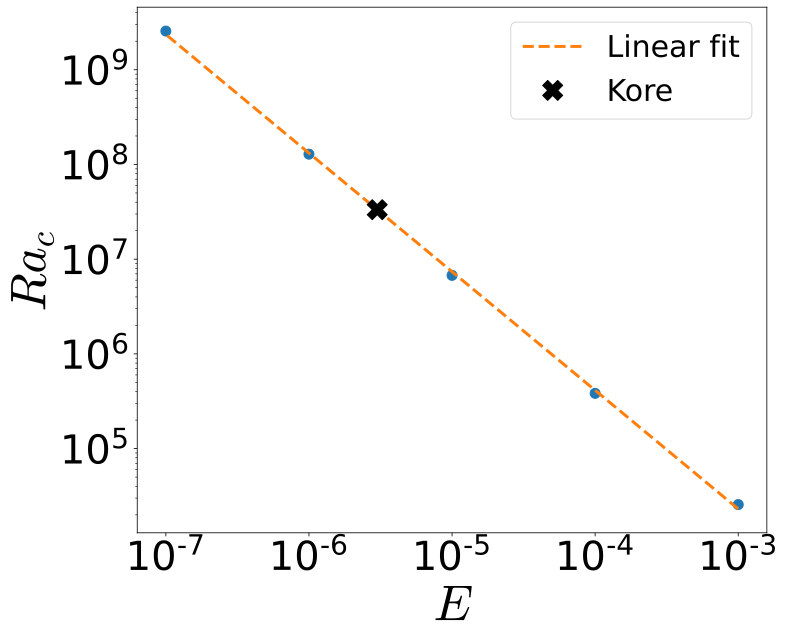

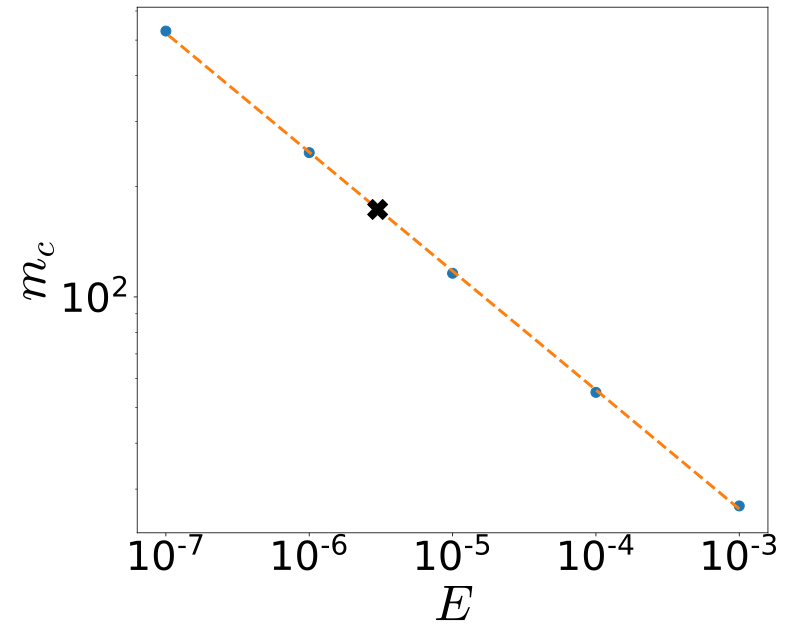

In [21]:
mcInterp, racInterp = interp_data(ekTest[1],chiTest[1],iplot=True)